## [analysis] Search Key Validation with TensorFlow Security Advisory (TFSA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

import settings
from utils import vplot, vprint

### Global Parameters

In [19]:
FRAMEWORKS = ['tensorflow','pytorch','opencv','keras','caffe']
FILTERED_DIR = settings.DATA_CONFIG['distilled_dir']
RAW_DIR = settings.DATA_CONFIG['raw_dir']
MANUAL_DIR = settings.DATA_CONFIG['manual_dir']

TFSA_FILE =  FILTERED_DIR + "security_advisory_tensorflow.csv"

### Load Data

In [3]:
df = pd.read_csv(TFSA_FILE)
df[:1]

,TFSA,CVE Number,Patches,Issue Description,Impact,Vulnerable Versions,Mitigation,Credits,Attribution
0,BMP File Parser Out-of-bounds Read.,CVE-2018-21233,None,The BMP (bitmap image file graphics format) d...,The most likely consequence of this vulnerabi...,"TensorFlow 1.3.0, 1.3.1, 1.4.0, 1.4.1, 1.5.0,...",We have patched the vulnerability in GitHub c...,This issue was discovered by the Blade Team o...,None


### Regex Evaluation

#### Get Commit ID

TF team is used to put the commit URLs in TFSA, hence we can extract full commit ID which start with "commit/" from the commit URLs.

In [4]:
REGEX_COMMIT_ID = "(?<=commit\/)\w+"

df['commits'] = df['Patches'].str.findall(f"({REGEX_COMMIT_ID})", flags=re.IGNORECASE)

##### Denoise

In [5]:
df['TFSA'] = df['TFSA'].str.replace('unitialized', 'uninitialized', case=False)
df['TFSA'] = df['TFSA'].str.replace('`', '', case=False)

#### Evaluate Vulnerability Search Key

##### Define Search Key

In [6]:
REGEX = {
        # numeric
        'division by zero':r'div(i(de|sion)(s)?)?.by.(zero|0)', # CWE-369
        'integer truncation':r'int(eger)?.truncation', # CWE-197
        'integer overflow':r'int(eger)?.overflow', # CWE-190
        'floating point exception':r'floating.point.exception|\bfpe\b',
        # memory
        'out of memory':r'out(side)?.of.memory|\boom\b',
        'memory leak':r'(data|memory).leak',
        'memory corruption':r'(data|memory).corruption|bad.alloc',
        'infinite loop':r'infinite.loop',
        'invalid memory access':r'invalid.memory.access|access.(\w+.)?invalid.memory|write.(\w+.)?immutable.memory|access.(\w+.)?undefined.memory',
        'arbitrary memory access':r'arbitrary.memory.(read|write|access)',
        'null pointer dereference':r'null(.)?(pointer|ptr)?(.)?deref(erence)?|deref(erenc(e|ing))?.of.null(.)?(pointer|ptr)?',
        'reference binding to null pointer':r'reference.binding.to.null(.)?(.)?(pointer|ptr)?',
        'null pointer exception':r'null(.)?(pointer|ptr)?(.)?exception|\bnpe\b',
        'use after free':r'use.after.free', # CWE-416
        # buffer
        'heap buffer overflow':r'heap.(buffer.)?overflow|out.of.buffer', # CWE-122
        'stack overflow':r'stack.overflow(?!.com)', # CWE-121
        'out of bound read':r'(heap.)?(out(side)?.of.bound(s)?|\boob\b).read|read.(out(side)?.of.bound(s)?|\boob\b)', # CWE-125
        'out of bound write':r'(heap.)?(out(side)?.of.bound(s)?|\boob\b).write|write.(out(side)?.of.bound(s)?|\boob\b)', # CWE-787
        'out of bound access':r'(heap.)?(out(side)?.of.bound(s)?|\boob\b).access|access.(out(side)?.of.bound(s)?|\boob\b)|(heap.)?(out(side)?.of.bound(s)?|\boob\b)(?!.(read|write))',
        # resource
        'uninitialized':r'uninitialized',
        'validation':r'((incomplete|incorrect|lack.of|invalid|missing).)?\bvalidat(e|ion)(d|s)?\b(?!.(dataset|set|data|loss|accuracy|result|gradient|step|error))',
        # other
        'denial of service':r'denial.of.service|\bdos\b',
        'type confusion':r'type.confusion',
        'core dump':r'core.dump',
        'crash':r'crash',
        'undefined behavior':r'undefined.behavio(u)?r|misbehave',
        'segmentation fault':r'seg(ment)?(ation)?(.)?fault', # improper memory access
        'arbitrary code execution':r'arbitrary.code.execution',
        'security':r'(in)?secur(e|ity)',
        'deadlock':r'dead(.)?lock',
        'check fail':r'check.(.)?fail|fail(ing|ed)?(.)?check|assertion.fail',
        'code injection':r'code injection',
        'abort':r'abort',
        'format string':r'format.string|string.format',
        'vuln':r'vuln',
}

In [7]:
REGEX_ENHENCE = {
    'race condition':r'\brac(e|ing)', # CWE-362
    'improper access control':r'unauthenticated|gain.access|permission', # CWE-284
    'attack':r'attack',
    'threat':r'threat',
    'violate':r'violate',
    'fatal':r'fatal',
    'overrun':r'overrun', 
    'underflow':r'underflow',
    'remote code execution':r'remote.code.execution|\brce\b',
    'cve':r'\bcve\b',
    'cwe':r'\bcwe\b',
    'malicious':r'malicious',
    'poison':r'posion',
    #------------------------------- Not mention by Related Work -----------------------------------
    'overflow': r'overflow(?!.com)?', # avoid stackoverflow.com
    'safety':r'unsafe|thread.safe|safer',
    'dead code':r'dead(.)?code', # CWE-561 
    'shape check':r'shape.check|check.shape', 
}

In [8]:
class VulnerabilityRegex:
    regex = REGEX
    regex_enhence = REGEX_ENHENCE
    
    def __init__(self):
        pass
    
    @staticmethod
    def basic():
        return '|'.join(list(VulnerabilityRegex.regex.values()))

    @staticmethod
    def enhence():
        return '|'.join(list(VulnerabilityRegex.regex_enhence.values()))
    
    @staticmethod
    def normalize_searchkey(df_col):
        col = df_col.copy()
        for key,value in VulnerabilityRegex.regex.items():
            col = col.str.replace(value, key, case=False, regex=True)
        return col

    @staticmethod
    def normalize_enhence_searchkey(df_col):
        col = df_col.copy()
        for key,value in VulnerabilityRegex.regex_enhence.items():
            col = col.str.replace(value, key, case=False, regex=True)
        return col
    
VulnerabilityRegex.basic()

'div(i(de|sion)(s)?)?.by.(zero|0)|int(eger)?.truncation|int(eger)?.overflow|floating.point.exception|\\bfpe\\b|out(side)?.of.memory|\\boom\\b|(data|memory).leak|(data|memory).corruption|bad.alloc|infinite.loop|invalid.memory.access|access.(\\w+.)?invalid.memory|write.(\\w+.)?immutable.memory|access.(\\w+.)?undefined.memory|arbitrary.memory.(read|write|access)|null(.)?(pointer|ptr)?(.)?deref(erence)?|deref(erenc(e|ing))?.of.null(.)?(pointer|ptr)?|reference.binding.to.null(.)?(.)?(pointer|ptr)?|null(.)?(pointer|ptr)?(.)?exception|\\bnpe\\b|use.after.free|heap.(buffer.)?overflow|out.of.buffer|stack.overflow(?!.com)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b).read|read.(out(side)?.of.bound(s)?|\\boob\\b)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b).write|write.(out(side)?.of.bound(s)?|\\boob\\b)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b).access|access.(out(side)?.of.bound(s)?|\\boob\\b)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b)(?!.(read|write))|uninitialized|((incomplete|incorrect|lack.o

##### Apply Search Key

In [9]:
df['keyword'] = df['TFSA'].str.extract(f"({VulnerabilityRegex.basic() + '|' + VulnerabilityRegex.enhence()})", flags=re.IGNORECASE)[0].str.lower()
df['keyword'] = VulnerabilityRegex.normalize_searchkey(df['keyword'])
df['keyword'] = VulnerabilityRegex.normalize_enhence_searchkey(df['keyword'])
# df['TFSA'].str.findall(f"({TAXONOMY_REGEX})", flags=re.IGNORECASE)

##### Visualize Search Key

In [10]:
df['keyword'] = df['keyword'].fillna('unknown')
df['keyword'].unique()

array(['out of bound read', 'null pointer dereference', 'vuln', 'unknown',
       'invalid memory access', 'heap buffer overflow',
       'segmentation fault', 'out of bound write', 'denial of service',
       'out of bound access', 'memory corruption', 'validation',
       'memory leak', 'format string', 'integer truncation', 'abort',
       'crash', 'undefined behavior', 'overflow', 'uninitialized',
       'check fail', 'type confusion',
       'reference binding to null pointer', 'division by zero',
       'stack overflow', 'integer overflow', 'floating point exception',
       'use after free', 'arbitrary code execution',
       'null pointer exception', 'infinite loop', 'code injection',
       'arbitrary memory access', 'deadlock', 'out of memory', 'security',
       'core dump', 'safety'], dtype=object)

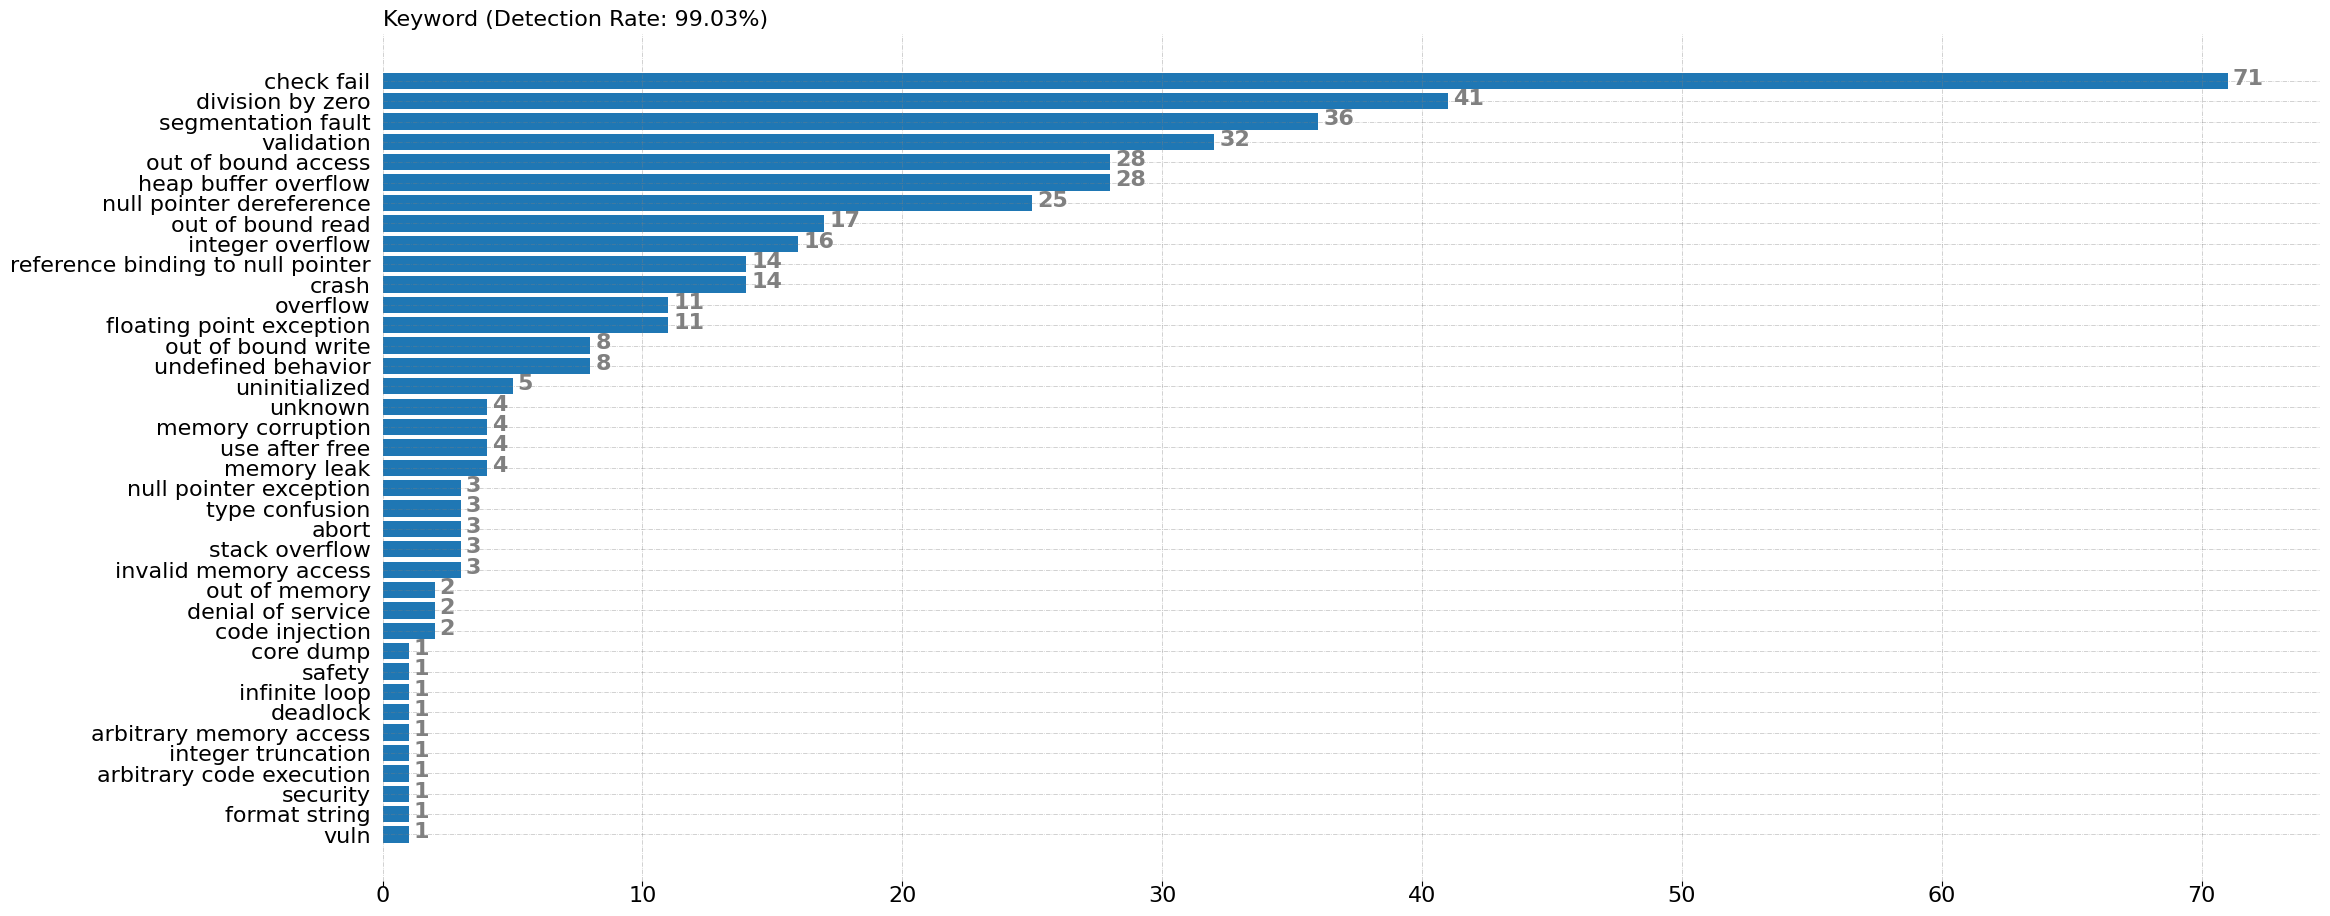

In [11]:
keyword_series = df['keyword'].value_counts()
detection_rate = (1 - keyword_series['unknown'] / keyword_series.values.sum()) * 100
vplot.barh(keyword_series, title=f"Keyword (Detection Rate: {detection_rate:.2f}%)", bar_height=0.3, fontsize=16)

### Outlier

In [12]:
vprint.df_col_by_keyword(df=df, keyword='unknown', search_col_name='keyword', info_col_name='TFSA', n=100)

4 	 Old Snappy Library Usage Resulting in Memcpy Parameter Overlap
396 	 CHECK_EQ fail in tf.raw_ops.TensorListResize
405 	 CHECK_EQ fail via input in SparseMatrixNNZ
407 	 Invalid char to bool conversion when printing a tensor
Total:4


### Summary of Performance on Official Data

In [13]:
print(f"Total Record: {len(df)}")
print(f"Outlier: {round(len(df) * (1-detection_rate / 100))}")
print(f"Detection Rate on TFSA: {detection_rate:.2f}%")

Total Record: 412
Outlier: 4
Detection Rate on TFSA: 99.03%


### Summary of Performance on GitHub Data

In [39]:
def get_latent_vuln(framework):
    filename = FILTERED_DIR + f'vuln_{framework}_pr+commit.csv'
    return pd.read_csv(filename)

def get_manual_vuln():
    filename = MANUAL_DIR + f'vulnerability_manual.xlsx'
    sheetname = 'manual'
    return pd.read_excel(filename,sheet_name=sheetname)

total_latent_vuln = 0
total_manual_vuln = 0

for framework in FRAMEWORKS:
    fdf = get_latent_vuln(framework)
    total_latent_vuln += len(fdf)
    
mdf = get_manual_vuln()
total_manual_vuln = len(mdf[mdf['Source'] == 'Unofficial'])

print(f"Accuracy Rate on GitHub: {total_manual_vuln / total_latent_vuln * 100:.2f}%")

Accuracy Rate on GitHub: 82.39%
